In [1]:
import math
import random
# import minigrid
import numpy as np
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
# from array2gif import write_gif
# from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper


import gym_examples
from models import *
from utils import *

plt.ioff()


pygame 2.1.0 (SDL 2.0.16, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
num_skills = 4
# skill_eps_len = 10  # 90 10
# skill_eps_count = 10
num_episodes = 1000  # 600
# discount = 0.99
# final_step_discount = 0.99
lr_pred = 1e-4
# lr_reg = 1e-4
lr_policy = 1e-4
# lr_extractor = 1e-4
BATCH_SIZE = 32 # 64  # 128
GAMMA = 0.99
# epsilon: linear decay
EPS_START = 0.9
EPS_MIN = 0.05
EPS_END = 0
# EPS_DECAY = 50000
TAU = 0.005
# features_dim = 32 # 128
hid_dim = 32
q_memory = ReplayMemory(96)
predictor_memory = MemoryDataset(96) # 300-600
# termination:length > 5
terminate_prob = 0.05
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'skill', 'reward', 'init_terminal'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make('gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
# env = gym_examples.OneHot(env)
env = gym_examples.AgentLocation(env)
# env = gym_examples.FullFrame(env)

n_actions = env.action_space.n
obs_dim = env.observation_space.shape[-1]
# obs, info = env.reset()
print(obs_dim)

2


/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(


In [4]:
predictor_net = Head(obs_dim * 2, num_skills, hid_dim=hid_dim, if_softmax=False).to(device)
regulizer_net = Head(obs_dim, num_skills, hid_dim=hid_dim, if_softmax=False).to(device)

policy_net = Head(obs_dim, n_actions*num_skills, hid_dim=hid_dim,).to(device)
target_net = Head(obs_dim, n_actions*num_skills, hid_dim=hid_dim,).to(device)
target_net.eval()
target_net.load_state_dict(policy_net.state_dict())

pred_optimizer = optim.AdamW(predictor_net.parameters(), lr_pred)
reg_optimizer = optim.AdamW(regulizer_net.parameters(), lr_pred)
policy_optimizer = optim.AdamW(policy_net.parameters(), lr_policy)

In [5]:
it = 0
def select_action(state, skill, eps_done):
    global it
    eps_threshold = epsilon(EPS_START, EPS_END, eps_done, EPS_MIN)
    if it > 5 and random.random() < terminate_prob:
        it = 0
        return None
    elif random.random() > eps_threshold:
        it += 1
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            q_values = policy_net(state).reshape((-1, n_actions, num_skills))[:,:, skill]
            return q_values.max(1).indices.view(-1, 1)
    else:
        it += 1
        return torch.tensor([[env.action_space.sample()]], device=device,) # dtype=torch.long

In [6]:
def compute_td_error():
    if len(q_memory) < BATCH_SIZE:
        return
    transitions = q_memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None]
    )
    state_batch =  torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    skill_batch = torch.cat(batch.skill)
    state_action_values = policy_net(state_batch).reshape((-1, n_actions, num_skills))[torch.arange(BATCH_SIZE), action_batch.squeeze().int()] # [B,N_Skills]

    next_state_values = torch.zeros((BATCH_SIZE, num_skills), device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = (
            target_net(non_final_next_states).reshape(-1, n_actions, num_skills)
            .max(1)
            .values
        )
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # print(reward_batch.shape)
    # print(next_state_values.shape)
    # print(state_action_values.shape)
    # print(reward_batch)
    # print(next_state_values)
    # print(state_action_values)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    td_error = criterion(
        state_action_values, expected_state_action_values
    )
    # print(next_state_values * GAMMA, reward_batch.unsqueeze(1))
    # print(td_error)

    # Optimize the model
    policy_optimizer.zero_grad()
    td_error.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    policy_optimizer.step()

    return td_error

In [7]:
def plot_skill_for_state(init_state, fname, size=10):
    map = np.zeros((size, size))
    init_state = torch.tensor(
            init_state, dtype=torch.float32, device=device
        ).unsqueeze(0)
    for i in range(size):
        for j in range(size):
            state = torch.tensor(
            [i, j], dtype=torch.float32, device=device
        ).unsqueeze(0)
            init_term = torch.cat((init_state, state), dim=1)
            map[i][j] = predictor_net(init_term).argmax(dim=1).squeeze().item()/num_skills
    plt.imshow(map, cmap='rainbow')
    plt.savefig(fname)

In [8]:
def plot_trajectories(fname, options=None):
    num_eval_episodes = 1 if options else 4
    plt.figure()
    plt.xlim(0, 10)
    plt.ylim(0, 10)
    for skill in range(num_skills):
        for eps in range(num_eval_episodes):
            obs, _ = env.reset(options=options)
            trajectory = [obs]
            for t in range(20):
                obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(
                    0
                )
                action = (
                    target_net(obs)
                    .reshape(-1, n_actions, num_skills)[:, :, skill]
                    .max(1)
                    .indices.view(1, 1)
                )

                obs, reward, terminated, truncated, _ = env.step(action.item())
                trajectory.append(obs+np.random.uniform(-0.1, 0.1, 2))

                done = terminated | truncated

                if done or action is None:
                    break
            trajectory = [*zip(*trajectory)]
            # flip upside down
            plt.plot(trajectory[1], trajectory[0], '-o', c=cm.rainbow(skill/num_skills), label=skill)
    # plt.legend()
    if options:
        plt.plot(options[0], options[1], '*', c='black')
    plt.plot()
    plt.grid()
    plt.savefig(fname)
    plt.close()

In [9]:
called_time = 0
def update_pred(net, optimizer):
    global called_time
    train_dataset, valid_dataset = torch.utils.data.random_split(predictor_memory, [0.8, 0.2])
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
    stopper = EarlyStopper(patience=2000, min_delta=-0.001, if_save=True)
    training_losses = []
    valid_losses = []

    for epoch in tqdm(range(5000)):
        num_batch = 0
        train_loss_sum = 0
        net.train()
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = net(X)
            # print(pred.shape, y.shape)
            loss = torch.nn.functional.cross_entropy(pred, y)
            num_batch += 1
            train_loss_sum += loss

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        training_losses.append(train_loss_sum/num_batch)
        
        net.eval()
        valid_loss_sum = 0
        num_batch = 0
        for batch, (X, y) in enumerate(valid_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = net(X)
            loss = torch.nn.functional.cross_entropy(pred, y)
            num_batch += 1
            valid_loss_sum += loss

        valid_loss = valid_loss_sum/num_batch
        valid_losses.append(valid_loss)

        if stopper.early_stop(valid_loss, state_dict=net.state_dict(), path="vic_pred_temp.dict",):
            net.load_state_dict(torch.load("vic_pred_temp.dict"))
            break
    plot_skill_for_state([4,4], fname=f"eval/vic_pred_map_center_{called_time}.png")
    plot_skill_for_state([7,7], fname=f"eval/vic_pred_map_corner_{called_time}.png")
    plt.figure()
    plt.plot([*range(len(training_losses))], [i.item() for i in training_losses], label='train')
    plt.plot([*range(len(valid_losses))], [i.item() for i in valid_losses], label='valid')
    plt.legend()
    plt.savefig(f"eval/vic_pred_loss_{called_time}.png")
    plt.close()
    called_time += 1
    net.train()
    return valid_loss

    # return loss


Episode 31 predictor_memory length: 32


  9%|▉         | 438/5000 [00:00<00:03, 1219.07it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (26x4 and 2x32)

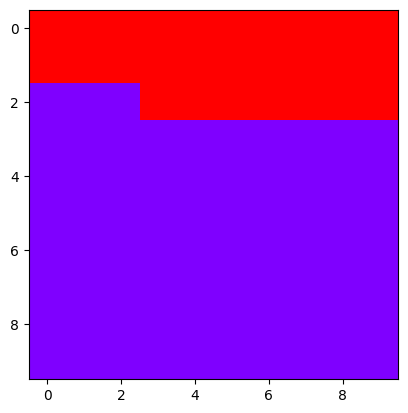

In [10]:
# td_error_list = []
reward_list = []
pred_loss_list = []
reg_loss_list = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(
        0
    )
    skill = torch.tensor(
        [random.choice([*range(num_skills)])], device=device
    ).unsqueeze(
        0
    )  # [1, 1]

    secondary_memory = []
    action = None
    while action is None:
        action = select_action(state, skill.item(), i_episode)
    while action is not None:
        observation, _, terminated, truncated, _ = env.step(
            action.item()
        )  # ignore reward
        done = terminated or truncated
        next_state = torch.tensor(
            observation, dtype=torch.float32, device=device
        ).unsqueeze(0)

        if terminated:
            secondary_memory.append((state, action, None))
        else:
            secondary_memory.append((state, action, next_state))

        state = next_state
        action = select_action(state, skill.item(), i_episode)

        if done:
            break

    initial_state = secondary_memory[0][0]
    init_terminal = torch.cat((initial_state, state), dim=1)
    predictor_memory.add((init_terminal.squeeze(0), skill.squeeze()))
    

    if i_episode % 32 == 31:
        print(f"Episode {i_episode} predictor_memory length: {len(predictor_memory)}")
        pred_loss = update_pred(predictor_net, pred_optimizer)
        reg_loss = update_pred(regulizer_net, reg_optimizer)
        pred_loss_list.append(pred_loss)
        reg_loss_list.append(reg_loss)
        with torch.no_grad():
            for transition in q_memory.memory:
                # TODO: change this
                transition._replace(
                    reward = torch.log_softmax(predictor_net(transition.init_terminal), dim=1) - torch.log_softmax(regulizer_net(state), dim=1)
                ) # bug # log instability? 

    with torch.no_grad():
        reward = torch.log_softmax(predictor_net(init_terminal), dim=1) - torch.log_softmax(regulizer_net(state), dim=1)
        # - torch.nn.functional.cross_entropy(predictor_net(init_terminal), skill.squeeze(0).to(device)).unsqueeze(0) 
        # - prev_regularizer_net(state_feature)[:, skill.item()]
        # print(reward)
        reward_list.append(reward)

    for s, a, ns in secondary_memory:
        q_memory.push(s, a, ns, skill, reward, init_terminal)

    # train 10 times
    # TODO: prioritized queue
    # td_error = None
    if i_episode % 32 == 31:
        
        td_errors = []
        for j in tqdm(range(100)):
            td_error = compute_td_error()
            if td_error:
                td_errors.append(td_error)
        print(f"Episode {i_episode} done. {td_errors}")

        if td_errors:
            plt.figure()
            plt.plot([*range(len(td_errors))], [i.item() for i in td_errors], label='train')
            print(td_errors)
            plt.savefig(f"eval/vic_policy_train_{i_episode//32}.png")
            plt.close()
            target_net.load_state_dict(policy_net.state_dict())
            # td_error_list.append(td_error)
            plot_trajectories(f"eval/vic_policy_trac_1_{i_episode//32}.png", options=[4,4])
            plot_trajectories(f"eval/vic_policy_trac_2_{i_episode//32}.png", options=[7,7])
    # else:
    #     td_error_list.append(torch.tensor(0))

    if i_episode > 0 and not i_episode % 100:
        torch.save(
            target_net.state_dict(), "target_net_{}.dict".format(i_episode)
        )

print("Complete")

In [ ]:
# for idx, r in enumerate(zip(*torch.cat(reward_list))):
#     print(r)
#     plt.plot([i.item() if type(i) == torch.Tensor else 0 for i in r], label=idx)
# plt.show()

In [ ]:
assert(False)

AssertionError: 

In [ ]:
env = gym.make("gym_examples/GridWorld-v0", size=10, render_mode="rgb_array")
# env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym_examples.AgentLocation(env)
env = gym.wrappers.RecordVideo(
    env,
    video_folder="eval",
    name_prefix="eval",
    episode_trigger=lambda x: True,
)
num_eval_episodes = 8
vis_map = np.zeros((10, 10))
final_map = np.zeros((10, 10))
skill = 3
for episode_num in range(num_eval_episodes):
    obs, _ = env.reset()
    vis_map[obs[0]][obs[1]] = episode_num + 1
    initial_state = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    for t in range(100):
        obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(
            0
        )
        action = (
            target_net(obs)
            .reshape(-1, n_actions, num_skills)[:, :, skill]
            .max(1)
            .indices.view(1, 1)
        )
        # action = select_action(obs, 4, 100000)

        if action is not None:
            obs, reward, terminated, truncated, _ = env.step(action.item())
            vis_map[obs[0]][obs[1]] = episode_num + 1

        done = terminated | truncated

        if done or action is None:
            break
    final_map[obs[0]][obs[1]] = final_map[obs[0]][obs[1]] + 1
    obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(
            0
        )
    with torch.no_grad():
        init_terminal = torch.cat((initial_state, obs), dim=1)
        # NOTE: may need to change
        reward = -torch.nn.functional.cross_entropy(
            predictor_net(init_terminal), torch.tensor([7]).to(device)
        ).unsqueeze(0)
        print(reward)
    # if map is not None:
    #     map += (1+episode_num)*obs
    # else:
    #     map = (1+episode_num)*obs
# print(map.reshape((10, 10)))
print(vis_map)
print(final_map)
env.close()

# [0. 0. 0. 0. 7. 4. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [5. 0. 0. 0. 0. 0. 3. 0. 0. 8.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]

/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/zhaoyutian/Documents/rl_experiments/eval folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
env = gym.make("gym_examples/GridWorld-v0", size=10, render_mode="rgb_array")
# env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym_examples.OneHot(env)
env = gym.wrappers.RecordVideo(
    env,
    video_folder="eval",
    name_prefix="eval",
    episode_trigger=lambda x: True,
)
num_eval_episodes = 8
vis_map = None

for episode_num in range(num_eval_episodes):
    obs, _ = env.reset()

    for t in range(100):
        obs = torch.tensor(
            obs, dtype=torch.float32, device=device
        ).unsqueeze(0)
        action = (
            target_net(obs).reshape(-1, n_actions, num_skills)[:,:, episode_num]
            .max(1)
            .indices.view(1, 1)
        )
        # action = select_action(obs, 4, 100000)
        
        if action is not None:
            obs, reward, terminated, truncated, _ = env.step(action.item())
            
        done = terminated | truncated

        if done or action is None:
            break
    if vis_map is not None:
        vis_map += (1+episode_num)*obs
    else:
        vis_map = (1+episode_num)*obs
print(vis_map.reshape((10, 10)))

env.close()

# [0. 0. 0. 0. 7. 4. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [5. 0. 0. 0. 0. 0. 3. 0. 0. 8.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]



/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(
/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/zhaoyutian/Documents/rl_experiments/eval folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x100 and 2x32)

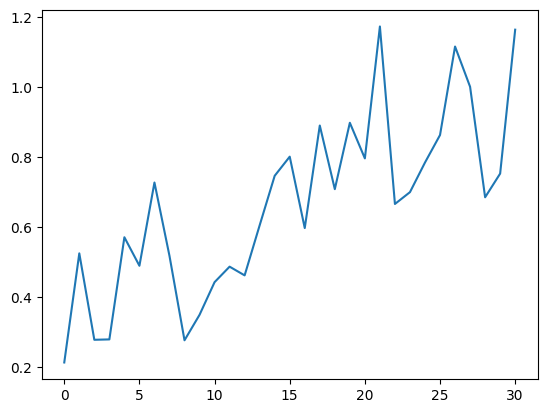

In [ ]:
plt.plot([i.item() if type(i) == torch.Tensor else 0 for i in pred_loss_list])

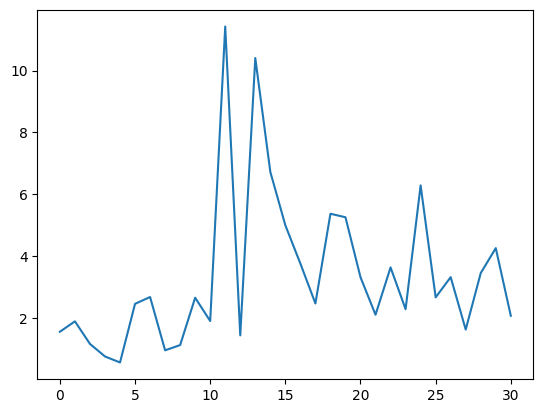

In [ ]:
plt.plot([i.item() if type(i) == torch.Tensor else 0 for i in td_error_list])

In [ ]:
# obs, _ = env.reset()

# input = torch.cat((torch.tensor(obs, dtype=torch.float, device=device).unsqueeze(0).repeat(2, 1), torch.eye(2).to(device)),dim=1)
# state_skills = predictor_net(input)
# state_skill_map = torch.argmax(state_skills, 1).reshape((10, 10)) # skills preferred by states # untouched?
# state_skill_value = torch.max(state_skills, 1).values.reshape((10, 10))
# skill_state = torch.argmax(state_skills, 0) # states preferred by skills
# skill_state_value = torch.max(state_skills, 0).values
# skill_state_map = torch.zeros((10, 10))
# for idx, i in enumerate(skill_state):
#     r = int(i/10)
#     c = i%10
#     skill_state_map[r][c] = 1+idx
# skill_state_map

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x102 and 4x32)

tensor([[0., 0., 8., 0., 4., 0., 0., 0., 0., 0.],
        [6., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 5.],
        [0., 0., 0., 0., 0., 0., 0., 3., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 7.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
env = gym.make("gym_examples/GridWorld-v0", size=10, render_mode="rgb_array")
# env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym_examples.OneHot(env)
env = gym.wrappers.RecordVideo(
    env,
    video_folder="eval",
    name_prefix="eval",
    episode_trigger=lambda x: True,
)
num_eval_episodes = 8
vis_map = None

for episode_num in range(num_eval_episodes):
    obs, _ = env.reset()

    for t in range(100):
        obs = torch.tensor(
            obs, dtype=torch.float32, device=device
        ).unsqueeze(0)
        action = (
            target_net(obs).reshape(-1, n_actions, num_skills)[:,:, 0]
            .max(1)
            .indices.view(1, 1)
        )
        # action = select_action(obs, 4, 100000)
        
        if action is not None:
            obs, reward, terminated, truncated, _ = env.step(action.item())
            
        done = terminated | truncated

        if done or action is None:
            break
    if vis_map is not None:
        vis_map += obs
    else:
        vis_map = obs
print(vis_map.reshape((10, 10)))

env.close()


/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/zhaoyutian/Documents/rl_experiments/eval folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Moviepy - Building video /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4.
Moviepy - Writing video /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4
